# Лабораторная работа 2. Визуализация градиентного спуска. Ландшафты потерь. Оптимайзеры.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# готовим функцию для красивой отрисовки градиента
def show_contours(objective,
                  x_lims=[-200.0, 202.0],
                  y_lims=[-200.0, 202.0],
                  x_ticks=100,
                  y_ticks=100):
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]
    res = []
    for x_index in range(X.shape[0]):
        res.append([])
        for y_index in range(X.shape[1]):
            x_val = X[x_index, y_index]
            y_val = Y[x_index, y_index]
            res[-1].append(objective(np.array([[x_val, y_val]]).T))
    res = np.array(res)
    plt.figure(figsize=(7,7))
    plt.contour(X, Y, res, 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

In [3]:
# расcчитаем градиентный спуск для фунции для 10 cумма(x^2), x = тензор 1 на 2. Инициализирован значением 8
# тензор
x = torch.tensor([200.,200.], requires_grad=True)

# сюда будем складывать значения тензора x при каждом шаге градиентного спуска
var_history = []

# сюда будем складывать значения функции при каждом шаге градиентного спуска
fn_history = []

# определяем функцию.
def function_parabola(variable):
    return 10 * (variable ** 2).sum()

# считаем шаг градиентного спуска
lr = 0.01
def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    variable.data -= lr * variable.grad
    variable.grad.zero_()

# реализуем градиентный спуск, думаем, что за 500 шагов справимся, и найдем минимум функции.
for i in range(500):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_parabola(x).data.cpu().numpy().copy())
    make_gradient_step(function_parabola, x)

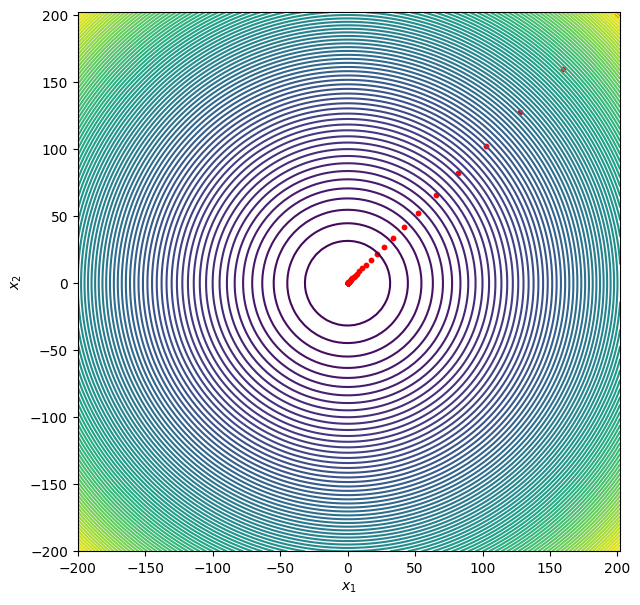

In [4]:
show_contours(function_parabola)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

## Задание 1. Сделайте трехмерную визуализацию сходимости градиентного спуска. Нарисуйте поверхность функции двух переменных для которой осуществлялся поиск минимума методом градиентного спуска. Отдельными точками другого цвета изобразите позиции которые рассматривались на каждом шаге градиентного спуска.

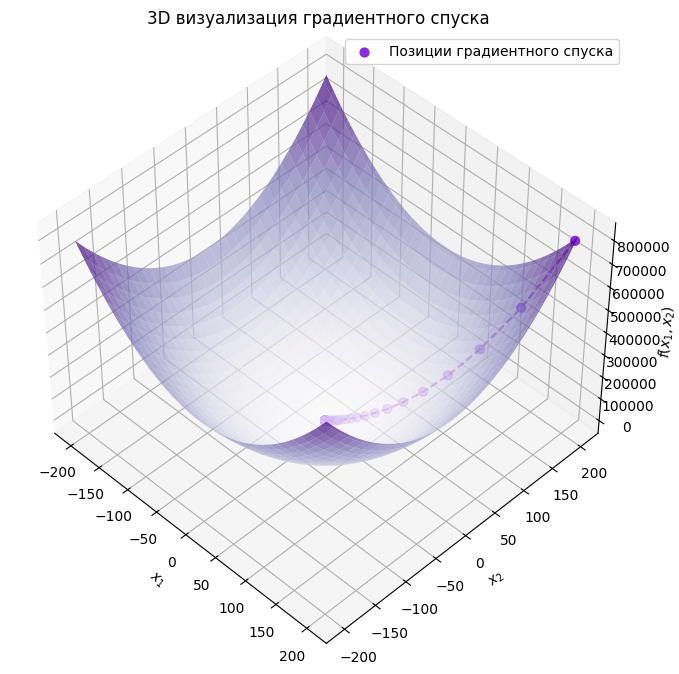

In [5]:
def plot_gradient_descent_3d(objective_function, var_history,
                             x_lims=[-200.0, 202.0], # ограничения по оX для отображаемой сетки
                             y_lims=[-200.0, 202.0], # ограничения по оY для отображаемой сетки
                             x_ticks=100,  # кол-во точек на оХ
                             y_ticks=100): # кол-во точек на оY

    # Вычисоение шагов для сетки по осям x и y (расстояние между соседними точками)
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks

    # Создание сетки значений X и Y для отображения поверхности функции
    # создаем 2 массива, которые содержат все координаты в пределах заданного диапазона, с шагами x_step и y_step
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]

    # Вычисление значений функции для каждой точки сетки
    # Z — это значения функции (расстояния на оси Z) для каждой пары (x, y)
    Z = np.array([[objective_function(np.array([x, y])) for y in Y[0]] for x in X[:, 0]])

    # Подготовка данных из истории градиентного спуска
    var_history_np = np.array(var_history)  # Преобразование истории переменных из списка в массив
    X_history, Y_history = var_history_np[:, 0], var_history_np[:, 1]  # Извлечение координат X и Y из истории
    Z_history = np.array([objective_function(np.array([x, y])) for x, y in zip(X_history, Y_history)])
    # Z_history — это значения функции для каждого шага градиентного спуска, вычисленные из истории X и Y

    # Создание фигуры для 3D графика
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')  # Добавление 3D осей

    # Визуализация
    ax.plot_surface(X, Y, Z, cmap='Purples', alpha=0.7)                                                     # Поверхность
    ax.scatter(X_history, Y_history, Z_history, color='#8A2BE2', s=40, label='Позиции градиентного спуска') # Точки
    ax.plot(X_history, Y_history, Z_history, color='#BA55D3', linestyle='--')                               # Линия

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$f(x_1, x_2)$')
    ax.set_title('3D визуализация градиентного спуска')

    ax.view_init(elev=45, azim=-45)
    plt.legend()
    plt.show()

plot_gradient_descent_3d(function_parabola, var_history)

## Задание 2. Для своего кода лабораторной работы №1 примените три разных оптимайзера. Постройте графики зависимости величины функции потерь от номера эпохи для всех трех оптимайзеров на одном графике сначала для обучающей выборки, потом для тестовой.

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import gaussian_filter1d

In [7]:
# Фиксируем случайные значения
np.random.seed(0)
torch.manual_seed(0)
# Определяем устройство для вычислений: GPU, если доступен, иначе CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Загружаем USPS датасет
USPS_train = torchvision.datasets.USPS('./', download=True, train=True)
USPS_test = torchvision.datasets.USPS('./', download=True, train=False)

# Преобразуем данные в тензоры и отправляем их на нужное устройство
X_train = torch.tensor(USPS_train.data).unsqueeze(1).float().to(device)
y_train = torch.tensor(USPS_train.targets, dtype=torch.long).to(device)
X_test = torch.tensor(USPS_test.data).unsqueeze(1).float().to(device)
y_test = torch.tensor(USPS_test.targets, dtype=torch.long).to(device)

100%|██████████| 6.58M/6.58M [00:01<00:00, 4.20MB/s]


100%|██████████| 1.83M/1.83M [00:01<00:00, 1.47MB/s]


In [9]:
# Определяем архитектуру модели
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)  # Первый сверточный слой
        self.act1 = nn.Tanh()  # Функция активации
        self.pool1 = nn.AvgPool2d(2, 2)  # Первый слой подвыборки
        self.conv2 = nn.Conv2d(6, 16, 5)  # Второй сверточный слой
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(2, 2)  # Второй слой подвыборки
        self.fc1 = nn.Linear(16 * 2 * 2, 120)  # Первый полносвязный слой
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(120, 84)  # Второй полносвязный слой
        self.act4 = nn.Tanh()
        self.fc3 = nn.Linear(84, 10)  # Выходной слой для 10 классов

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))  # Пропускаем через первый сверточный слой
        x = self.pool2(self.act2(self.conv2(x)))  # Пропускаем через второй сверточный слой
        x = x.view(x.size(0), -1)  # Разворачиваем тензор перед полносвязными слоями
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)  # Выходной слой без активации (для CrossEntropyLoss)
        return x

In [10]:
# Определяем три оптимизатора для сравнения их эффективности
optimizers = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}

In [11]:
# Гиперпараметры обучения
epochs = 30                        # Количество эпох
batch_size = 100                   # Размер мини-батча
loss_func = nn.CrossEntropyLoss()  # Функция потерь

test_loss_histories = {}  # История потерь на тестовой выборке
train_loss_histories = {}  # История потерь на обучающей выборке

In [12]:
# Обучение модели с разными оптимизаторами
for opt_name, opt_class in optimizers.items():
    print(f'\nОбучение с {opt_name}')
    model = LeNet5().to(device)  # Создаем новую модель для каждого оптимизатора
    optimizer = opt_class(model.parameters(), lr=0.001)  # Инициализируем оптимизатор

    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        order = np.random.permutation(len(X_train))  # Перемешиваем индексы обучающей выборки
        for start in range(0, len(X_train), batch_size):
            optimizer.zero_grad()  # Обнуляем градиенты перед новым шагом
            batch_indexes = order[start:start + batch_size]  # Формируем мини-батч
            X_batch = X_train[batch_indexes]  # Выбираем изображения
            y_batch = y_train[batch_indexes]  # Выбираем метки классов

            preds = model(X_batch)  # Получаем предсказания модели
            loss_value = loss_func(preds, y_batch)  # Вычисляем функцию потерь
            loss_value.backward()  # Вычисляем градиенты
            optimizer.step()  # Обновляем параметры модели

        train_loss_history.append(loss_value.item())  # Запоминаем значение функции потерь на обучении
        test_preds = model(X_test)  # Делаем предсказания на тестовом наборе
        test_loss_history.append(loss_func(test_preds, y_test).item())  # Вычисляем потери на тестовой выборке

        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss_value.item()}')

    train_loss_histories[opt_name] = train_loss_history  # Сохраняем историю потерь обучения
    test_loss_histories[opt_name] = test_loss_history  # Сохраняем историю потерь тестирования


Обучение с Adam
Epoch 1/30, Loss: 0.4994773864746094
Epoch 2/30, Loss: 0.1317719668149948
Epoch 3/30, Loss: 0.08200357109308243
Epoch 4/30, Loss: 0.15066365897655487
Epoch 5/30, Loss: 0.16999498009681702
Epoch 6/30, Loss: 0.21320192515850067
Epoch 7/30, Loss: 0.06122858449816704
Epoch 8/30, Loss: 0.05958840996026993
Epoch 9/30, Loss: 0.0809619277715683
Epoch 10/30, Loss: 0.08472349494695663
Epoch 11/30, Loss: 0.04541782662272453
Epoch 12/30, Loss: 0.07482921332120895
Epoch 13/30, Loss: 0.04401747137308121
Epoch 14/30, Loss: 0.008828897960484028
Epoch 15/30, Loss: 0.026804378256201744
Epoch 16/30, Loss: 0.009059145115315914
Epoch 17/30, Loss: 0.018251968547701836
Epoch 18/30, Loss: 0.04741522669792175
Epoch 19/30, Loss: 0.004830257501453161
Epoch 20/30, Loss: 0.0179675854742527
Epoch 21/30, Loss: 0.046898722648620605
Epoch 22/30, Loss: 0.01804332621395588
Epoch 23/30, Loss: 0.016511190682649612
Epoch 24/30, Loss: 0.030835481360554695
Epoch 25/30, Loss: 0.04547153785824776
Epoch 26/30, 

 **Выводы**:

 1. Adam — самый быстрый и точный
 2. SGD — обучается медленно, сходимость хуже.
 3. RMSprop — хороший результат, но немного нестабильный.

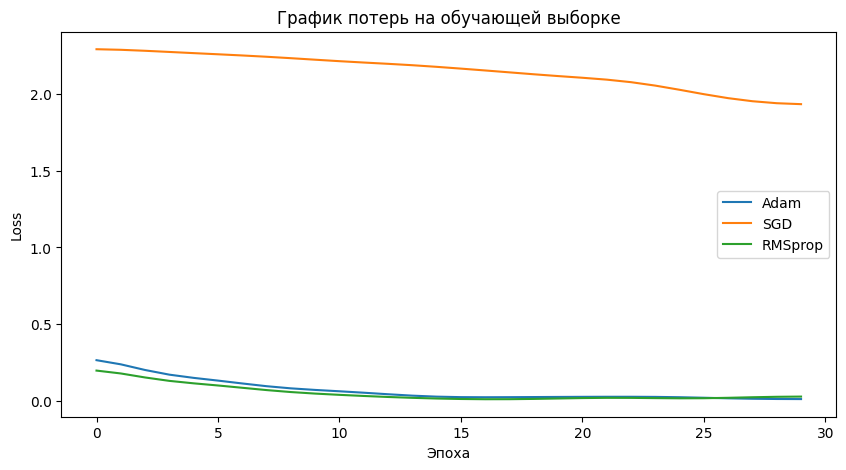

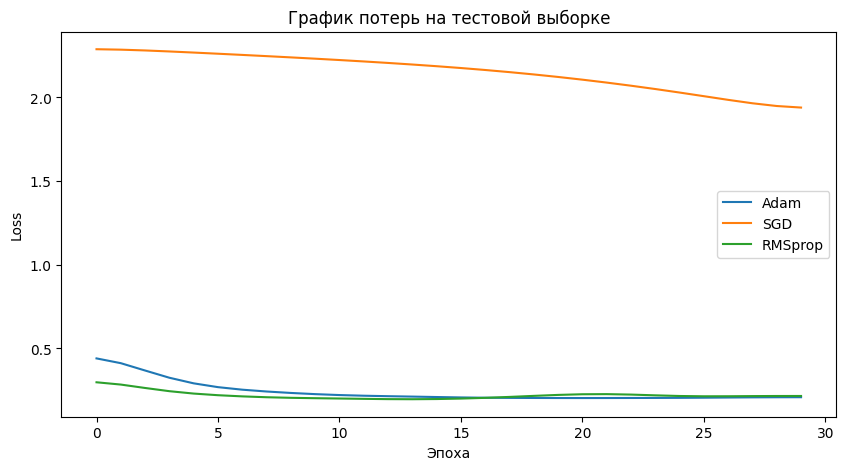

In [13]:
# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.title('График потерь на обучающей выборке')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
for opt_name, losses in train_loss_histories.items():
    plt.plot(gaussian_filter1d(losses, sigma=2), label=opt_name)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('График потерь на тестовой выборке')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
for opt_name, losses in test_loss_histories.items():
    plt.plot(gaussian_filter1d(losses, sigma=2), label=opt_name)
plt.legend()
plt.show()

## Задание 3. Изучите статью https://habr.com/ru/companies/skillfactory/articles/536606/. Попробуйте воспроизвести ее результаты в своем коде. Если не получится сделать анимацию, можно те же графики оставить статическими.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import torchvision.transforms as transforms
from torchvision import datasets

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Извлечение изображений и меток
X_train = mnist_train.data.numpy().reshape(-1, 784).astype(np.float32) / 255.0
y_train = mnist_train.targets.numpy().astype(np.float32)

# One-hot кодирование меток
oh = OneHotEncoder(categories='auto')
y_train_oh = oh.fit_transform(y_train.reshape(-1, 1)).toarray()  # One-hot-кодирование y-значений

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 51.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.05MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.94MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
hidden_0=50 # number of nodes of first hidden layer
hidden_1=500 # number of nodes of second hidden layer

# Set up cost function:
def costs(x,y,w_a,w_b,seed_):
        np.random.seed(seed_) # insert random seed
        w0=np.random.randn(hidden_0,784)  # weight matrix of 1st hidden layer
        w1=np.random.randn(hidden_1,hidden_0) # weight matrix of 2nd hidden layer
        w2=np.random.randn(10,hidden_1) # weight matrix of output layer
        w2[5][250] = w_a # set value for weight w_250,5(2)
        w2[5][251] = w_b # set value for weight w_251,5(2)
        a0 = expit(w0 @ x.T)  # output of 1st hidden layer
        a1=expit(w1 @ a0)  # output of 2nd hidden layer
        pred= expit(w2 @ a1) # output of final layer
        return np.mean(np.sum((y-pred)**2,axis=0)) # costs w.r.t. w_a and w_b

<ipython-input-8-52535a8b3498>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w2[5][250] = w_a # set value for weight w_250,5(2)
<ipython-input-8-52535a8b3498>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w2[5][251] = w_b # set value for weight w_251,5(2)


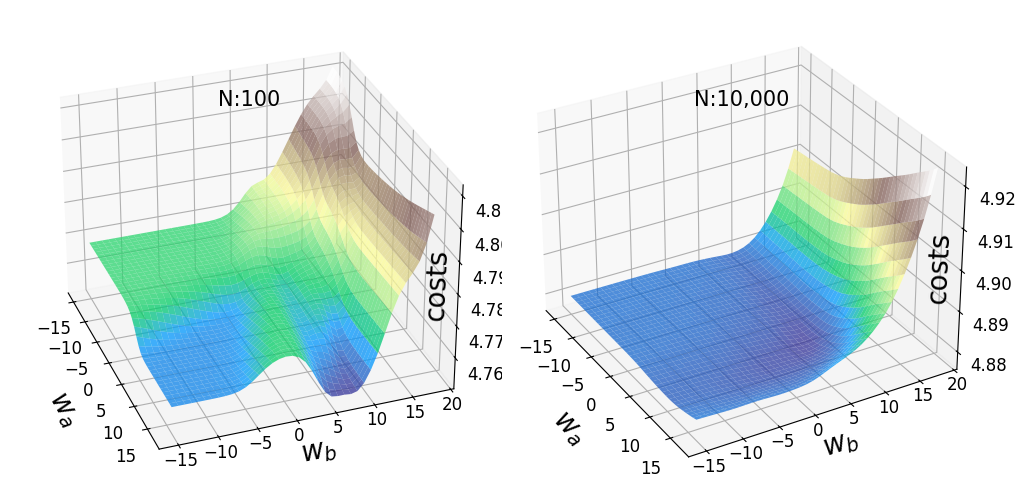

In [ ]:
from scipy.special import expit
# Set range of values for meshgrid:
m1s = np.linspace(-15, 17, 40)
m2s = np.linspace(-15, 18, 40)
M1, M2 = np.meshgrid(m1s, m2s) # create meshgrid

# Determine costs for each coordinate in meshgrid:
zs_100 = np.array([costs(X_train[0:100],y_train_oh[0:100].T,np.array([[mp1]]), np.array([[mp2]]),135)
                       for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_100 = zs_100.reshape(M1.shape) # z-values for N=100

zs_10000 = np.array([costs(X_train[0:10000],y_train_oh[0:10000].T
                               ,np.array([[mp1]]), np.array([[mp2]]),135)
                       for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_10000 = zs_10000.reshape(M1.shape) # z-values for N=10,000


# Plot loss landscapes:
fig = plt.figure(figsize=(10,7.5)) # create figure
ax0 = fig.add_subplot(121, projection='3d' )
ax1 = fig.add_subplot(122, projection='3d' )

fontsize_=20 # set axis label fontsize
labelsize_=12 # set tick label size

# Customize subplots:
ax0.view_init(elev=30, azim=-20)
ax0.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax0.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax0.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax0.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax0.set_title('N:100',y=0.85,fontsize=15) # set title of subplot

ax1.view_init(elev=30, azim=-30)
ax1.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax1.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax1.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax1.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax1.set_title('N:10,000',y=0.85,fontsize=15)

# Surface plots of costs (= loss landscapes):
ax0.plot_surface(M1, M2, Z_100, cmap='terrain', #surface plot
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
ax1.plot_surface(M1, M2, Z_10000, cmap='terrain', #surface plot
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
plt.tight_layout()
plt.show()

## Задание 4. В коде, полученном после выполнения задания 3, релизуйте по формулам один из оптимайзеров. Как изменится визуализация поиска минимума из тех же трех точек?

In [ ]:
# ваш код здесь